# Energy dataset

The dataset contains electricity service data of the state of Victoria, Australia, of 2016 days between 1 January 2015 and 6 October 2020. The 2016 rows are described by 14 features:

- **date**: `datetime`, the date of the recording
- **demand**: `float`, total daily electricity demand in MWh
- **RRP**: `float`, recommended retail price in AUD$ / MWh
- **demand_pos_RRP**: `float`, total daily demand at positive RRP in MWh
- **RRP_positive**: `float`, averaged positive RRP, weighted by the corresponding intraday demand in AUD$ / MWh
- **demand_neg_RRP**: `float`, total daily demand at negative RRP in MWh
- **RRP_negative**: `float`, average negative RRP, weighted by the corresponding intraday demand in AUD$ / MWh
- **frac_at_neg_RRP**: `float`, fraction of the day when the demand was traded at negative RRP
- **min_temperature**: `float`, minimum temperature during the day in Celsius
- **max_temperature**: `float`, maximum temperature during the day in Celsius
- **solar_exposure**: `float`, total daily sunlight energy in MJ/m²
- **rainfall**: `float`, daily rainfall in mm
- **school_day**: `boolean`, if students were at school on that day
- **holiday**: `boolean`, if the day was a state or national holiday

Some of them have been removed since DistilGPT-2 can manage only a reduced sequence of tokens, thus we removed some information, keeping only:

- **date**
- **demand**
- **RRP**
- **min_temperature**
- **max_temperature**
- **solar_exposure**
- **school_day**

The data has been preprocessed to respect the requirements needed for training the model, mainly dropping null values and dividing the time stamp into separated columns for each day, month and year.

## Imports and preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.spatial.distance import cdist
from imblearn.over_sampling import SMOTE
from statsmodels.tsa.stattools import acf


In [2]:
df = pd.read_csv('../Real_Datasets/complete_dataset.csv')
df = df.round(2)
df.dropna(inplace=True)
df.drop(['demand_pos_RRP', 'RRP_positive', 'RRP_positive', 'demand_neg_RRP', 'RRP_negative', 'frac_at_neg_RRP', 'rainfall', 'holiday'], axis=1, inplace=True)

In [3]:
df.head()

,date,demand,RRP,min_temperature,max_temperature,solar_exposure,school_day
0,2015-01-01,99635.03,25.63,13.3,26.9,23.6,N
1,2015-01-02,129606.01,33.14,15.4,38.8,26.8,N
2,2015-01-03,142300.54,34.56,20.0,38.2,26.5,N
3,2015-01-04,104330.72,25.01,16.3,21.4,25.2,N
4,2015-01-05,118132.20,26.72,15.0,22.0,30.7,N


In [4]:
def convertdate(df, date_column):
 
    df[date_column] = pd.to_datetime(df[date_column], format='%Y-%m-%d')
    
    df_filtered = df.copy()

    df_filtered['Day']=df_filtered['date'].dt.day
    df_filtered['Month']=df_filtered['date'].dt.month
    df_filtered['Year']=df_filtered['date'].dt.year

    df_filtered.drop(['date'], axis=1, inplace=True)
    
    df_filtered = df_filtered[[ 'Day', 'Month','Year','demand', 'RRP', 'min_temperature', 'max_temperature','solar_exposure', 'school_day']]

    return df_filtered

In [5]:
df_filtered = convertdate(df, 'date')


In [6]:
#df_filtered.to_csv('energy_prep_c.csv', index=False)

## Synthetic data import

The dataset so preprocessed has been used to train the generative model. After that the synthetic data are here imported and preprocessed. Since the generation could not always work fine, the data are sometimes misgenerated in wrong format or completely out of bounds (for instance a temperature of 10k ºC), they could not have physical sense (as for instance min_temp>max_temp) or even not generated. Thus the first thing done here is to convert, if needed, the data in the original format, remove the missing values and the values somehow out of the original values ranges, ensuring that these are relxed to admit values out of the proper ranges but still significative for the analysis.

In [7]:
df_sin = pd.read_csv('window_datasets/energy_window.csv')

In [8]:
df_sin.rename(columns={'MonthDay': 'Day'}, inplace=True)

In [9]:
df_sin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2105 entries, 0 to 2104
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Day              2105 non-null   int64  
 1   Month            2105 non-null   int64  
 2   Year             2105 non-null   int64  
 3   demand           2105 non-null   object 
 4   RRP              2100 non-null   object 
 5   min_temperature  2105 non-null   object 
 6   max_temperature  2105 non-null   float64
 7   solar_exposure   2105 non-null   float64
 8   school_day       2104 non-null   object 
dtypes: float64(2), int64(3), object(4)
memory usage: 148.1+ KB


In [10]:
df_sin.dropna(inplace=True)

In [11]:
df_sin['RRP'] = pd.to_numeric( df_sin['RRP'], errors='coerce')
df_sin['demand'] = pd.to_numeric( df_sin['demand'], errors='coerce')
df_sin['min_temperature'] = pd.to_numeric( df_sin['min_temperature'], errors='coerce')
df_sin['max_temperature'] = pd.to_numeric( df_sin['max_temperature'], errors='coerce')
df_sin['solar_exposure'] = pd.to_numeric( df_sin['solar_exposure'], errors='coerce')

In [12]:
df_sin.dropna(inplace=True)

In [13]:
df_sin = df_sin[df_sin['max_temperature'] >= df_sin['min_temperature']]


In [14]:
columns = df_filtered.columns.to_list()
excluded_columns = ['Day', 'Month', 'Year', 'school_day']
for col in columns:
    if col not in excluded_columns:    
        print('\n', col, '\n\nReal ranges: ',  ' min ', df_filtered[col].min(), ' max ', df_filtered[col].max(),
              '\nSynthetic ranges: ', ' min ', df_sin[col].min(), ' max ', df_sin[col].max(),)


 demand 

Real ranges:   min  85094.37  max  170653.84 
Synthetic ranges:   min  97.0  max  13402941.16

 RRP 

Real ranges:   min  -6.08  max  4549.65 
Synthetic ranges:   min  -1.76  max  290.42

 min_temperature 

Real ranges:   min  0.6  max  28.0 
Synthetic ranges:   min  0.8  max  27.2

 max_temperature 

Real ranges:   min  9.0  max  43.5 
Synthetic ranges:   min  9.6  max  40.8

 solar_exposure 

Real ranges:   min  0.7  max  33.3 
Synthetic ranges:   min  1.9  max  37.4


In [15]:
df_sin = df_sin[df_sin['demand'] >= 50000]
df_sin = df_sin[df_sin['demand'] <= 200653.84]

df_filtered = df_filtered[df_filtered['RRP'] <= 400]


## EDA confront between synthetic and real values

Here we have a first sight to the continue variables marginal distributions of both the real and synthetic data, in order to check that the model has been able to catch the main properties of the data.

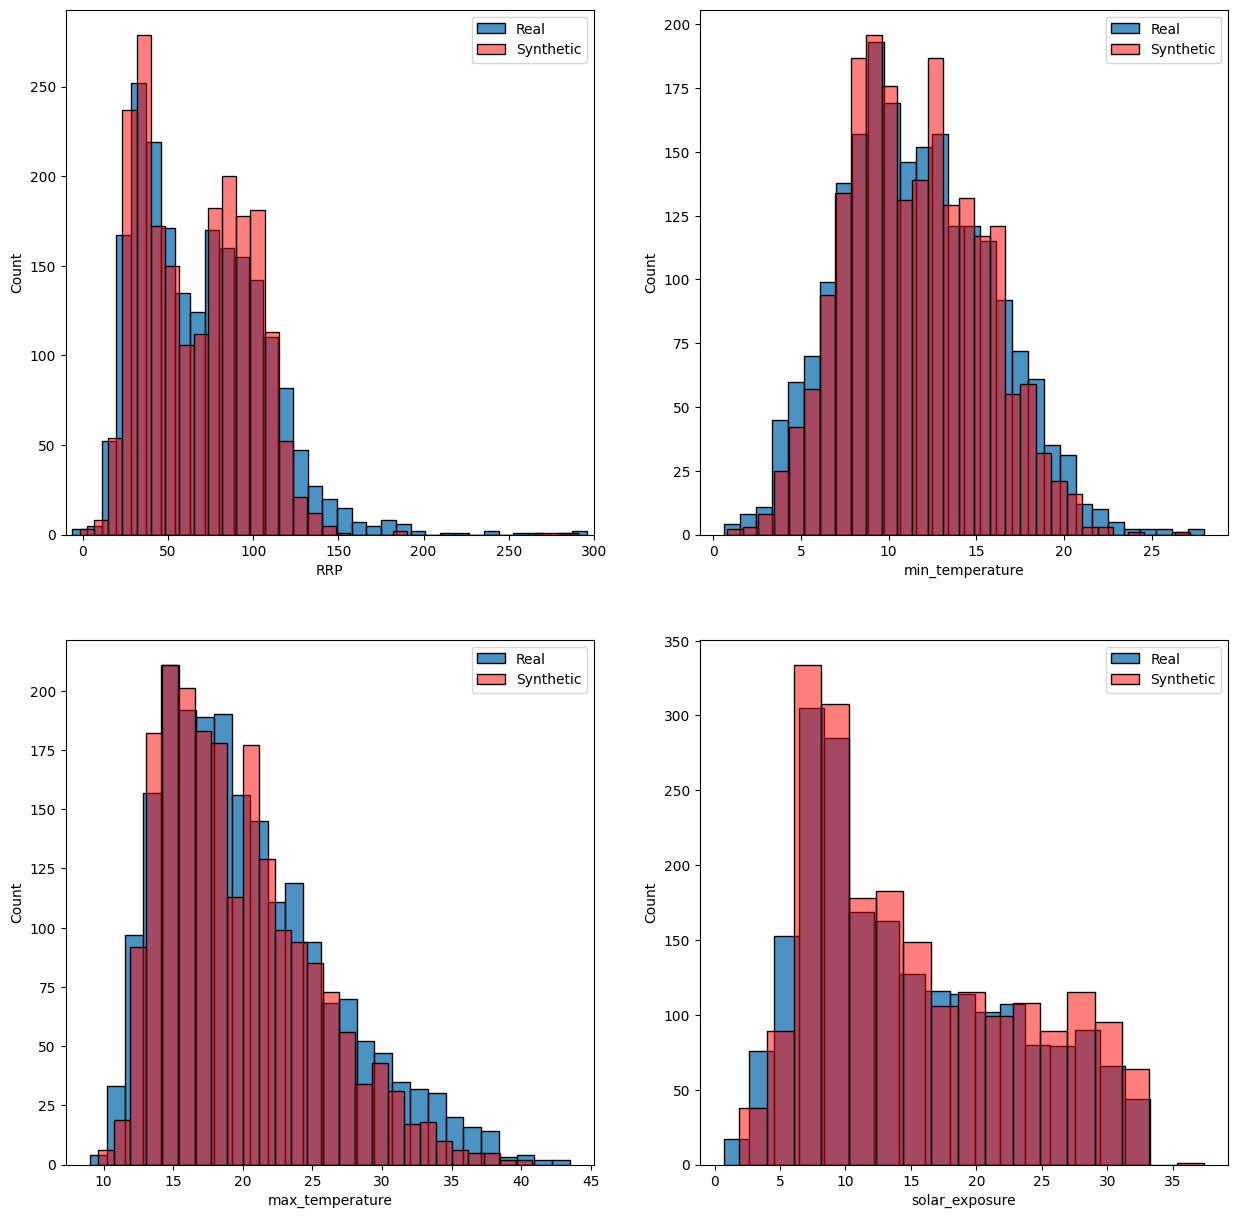

In [16]:
cols_to_plot = ['RRP',
 'min_temperature',
 'max_temperature',
 'solar_exposure',
]

plt.figure(figsize=(15, 15))
for i, col in enumerate(cols_to_plot):
    plt.subplot(2, 2, i+1)
    sns.histplot(data=df_filtered, x=col, label='Real', alpha=0.8,edgecolor='black', kde=False)
    sns.histplot(data=df_sin, x=col, color='red', alpha=0.5, label='Synthetic', edgecolor='black', kde=False)
    if col == 'RRP':
        plt.xlim(-10, 300)
    plt.legend()
plt.show()



In [17]:
df_real = df_filtered.copy()
df_synthetic = df_sin.copy()

def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

kl_divergences = {}

for column in cols_to_plot:
    real_hist, _ = np.histogram(df_real[column], bins=50, density=True)
    synth_hist, _ = np.histogram(df_synthetic[column], bins=50, density=True)
    
    real_hist = real_hist + 1e-10
    synth_hist = synth_hist + 1e-10
    
    real_hist = real_hist / np.sum(real_hist)
    synth_hist = synth_hist / np.sum(synth_hist)
    
    kl_div = kl_divergence(real_hist, synth_hist)
    kl_divergences[column] = kl_div

print("KL Divergences:")
for column, kl_div in kl_divergences.items():
    print(f"{column}: {kl_div:.2f}")

KL Divergences:
RRP: 0.26
min_temperature: 0.09
max_temperature: 0.05
solar_exposure: 1.03


In order to check the temporal properties of the data we set the timestamp back to the original format, so that the models can handle it.

In [18]:
df_filtered['Date'] = pd.to_datetime(df_filtered[['Year', 'Month', 'Day']])
df_filtered = df_filtered.drop(columns=['Day', 'Month', 'Year'])

df_sin['Date'] = pd.to_datetime(df_sin[['Year', 'Month', 'Day']])
df_sin = df_sin.drop(columns=['Day', 'Month', 'Year'])

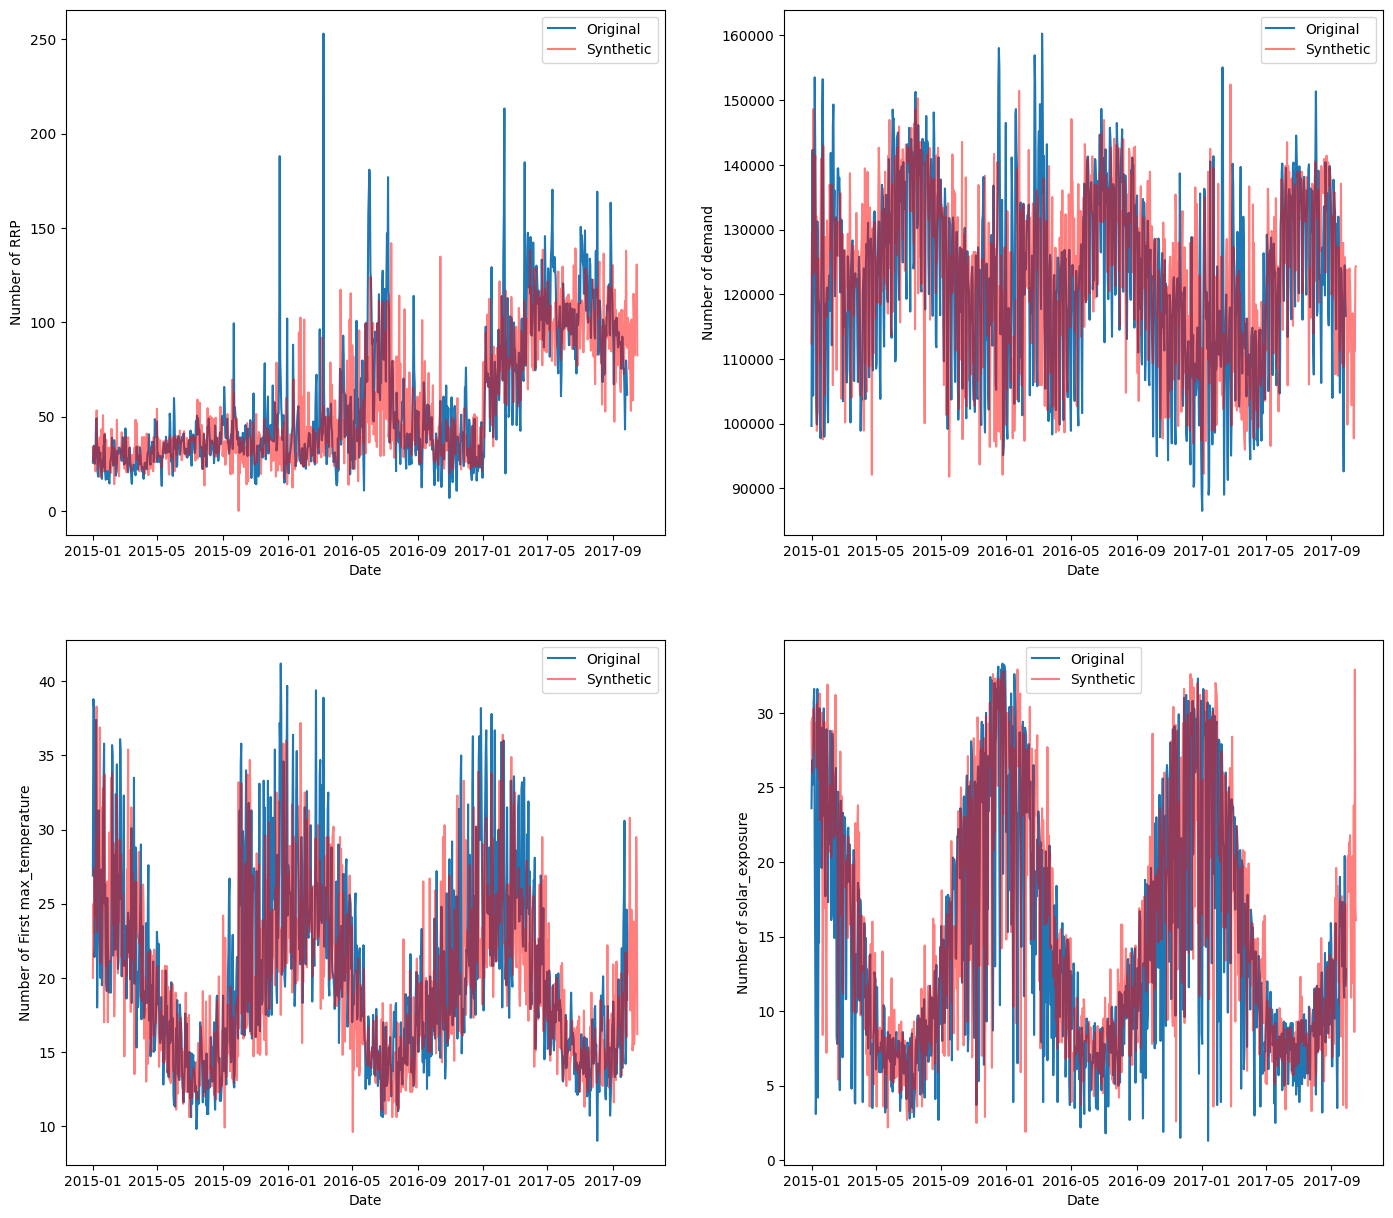

In [19]:
figure, ax = plt.subplots(2, 2, figsize=(17, 15))

ax1 = ax[0]
ax2 = ax[1]

ax1[0].plot(df_filtered['Date'].iloc[0:1000], df_filtered['RRP'].iloc[0:1000], label='Original')
ax1[0].plot(df_sin['Date'].iloc[0:1000], df_sin['RRP'].iloc[0:1000], color='red', alpha=0.5, label='Synthetic')
ax1[0].set_xlabel("Date")
ax1[0].set_ylabel("Number of RRP")
ax1[0].legend()

ax1[1].plot(df_filtered['Date'].iloc[0:1000], df_filtered['demand'].iloc[0:1000], label='Original')
ax1[1].plot(df_sin['Date'].iloc[0:1000], df_sin['demand'].iloc[0:1000], color='red', alpha=0.5,label='Synthetic')
ax1[1].set_xlabel("Date")
ax1[1].set_ylabel("Number of demand")
ax1[1].legend()

ax2[0].plot(df_filtered['Date'].iloc[0:1000], df_filtered['max_temperature'].iloc[0:1000], label='Original')
ax2[0].plot(df_sin['Date'].iloc[0:1000], df_sin['max_temperature'].iloc[0:1000], color='red', alpha=0.5,label='Synthetic')
ax2[0].set_xlabel("Date")
ax2[0].set_ylabel("Number of First max_temperature")
ax2[0].legend()

ax2[1].plot(df_filtered['Date'].iloc[0:1000], df_filtered['solar_exposure'].iloc[0:1000], label='Original')
ax2[1].plot(df_sin['Date'].iloc[0:1000], df_sin['solar_exposure'].iloc[0:1000], color='red', alpha=0.5,label='Synthetic')
ax2[1].set_xlabel("Date")
ax2[1].set_ylabel("Number of solar_exposure")
ax2[1].legend()

In [20]:
df_real = df_filtered.drop(columns=['Date', 'school_day'])
df_synthetic = df_sin.drop(columns=['Date', 'school_day'])

max_lag = 2
autocorrelations = {}

for column in df_real.columns:
    real_acf = acf(df_real[column], nlags=max_lag)
    synth_acf = acf(df_synthetic[column], nlags=max_lag)
    
    autocorrelations[column] = {
        'real': real_acf,
        'synthetic': synth_acf
    }


print("\nAutocorrelations:")
for column, acfs in autocorrelations.items():
    print(f"\n{column}:")
    print("Lag\tReal\tSynthetic")
    for lag in range(max_lag + 1):
        print(f"{lag}\t{acfs['real'][lag]:.4f}\t{acfs['synthetic'][lag]:.4f}")


Autocorrelations:

demand:
Lag	Real	Synthetic
0	1.0000	1.0000
1	0.6803	0.3908
2	0.3189	0.3900

RRP:
Lag	Real	Synthetic
0	1.0000	1.0000
1	0.7902	0.6572
2	0.6683	0.6791

min_temperature:
Lag	Real	Synthetic
0	1.0000	1.0000
1	0.7701	0.6087
2	0.6305	0.6033

max_temperature:
Lag	Real	Synthetic
0	1.0000	1.0000
1	0.6996	0.5465
2	0.5194	0.5414

solar_exposure:
Lag	Real	Synthetic
0	1.0000	1.0000
1	0.6876	0.6564
2	0.5826	0.6610


## Evaluation

We now evaluate the quality of the data. 


### Copied values

First of all we'd like to have an insight on the synthetic data row-wise, we check if row by row there are copied values of the real data and, if there, how many they are.

In [21]:
def compute_equals(df1, df2, col_to_drop=[]):

    df1['Date'] = pd.to_datetime(df1['Date'])
    df2['Date'] = pd.to_datetime(df2['Date'])
    
    matching_df1 = df1[df1['Date'].isin(df2['Date'])].copy()
    matching_df2 = df2[df2['Date'].isin(df1['Date'])].copy()
    original_indices = matching_df2.index
    
    matching_df1 = matching_df1.sort_values(by='Date').reset_index(drop=True)
    matching_df2 = matching_df2.sort_values(by='Date').reset_index(drop=True)

    matching_df1 = matching_df1.drop(columns=col_to_drop)
    matching_df2 = matching_df2.drop(columns=col_to_drop)

    
    
    numeric_cols = matching_df1.select_dtypes(include=[np.number]).columns
    
    results = []
    columns_matched = []
    summary_counter = Counter()
    matched_indices = []

    for i in range(len(matching_df1)):
        common_values = (matching_df1.loc[i, numeric_cols] == matching_df2.loc[i, numeric_cols])
        count_common = common_values.sum()
        matched_columns = numeric_cols[common_values].tolist()
        
        results.append(count_common)
        columns_matched.append(matched_columns)
        
        summary_counter.update(matched_columns)
        
        if count_common > 0:
            matched_indices.append({'index': original_indices[i], 'matched_columns': matched_columns})

    summary_report = dict(summary_counter)

    return results, columns_matched, summary_report, matched_indices

In [22]:
distances, _, report, _ = compute_equals(df_filtered, df_sin)

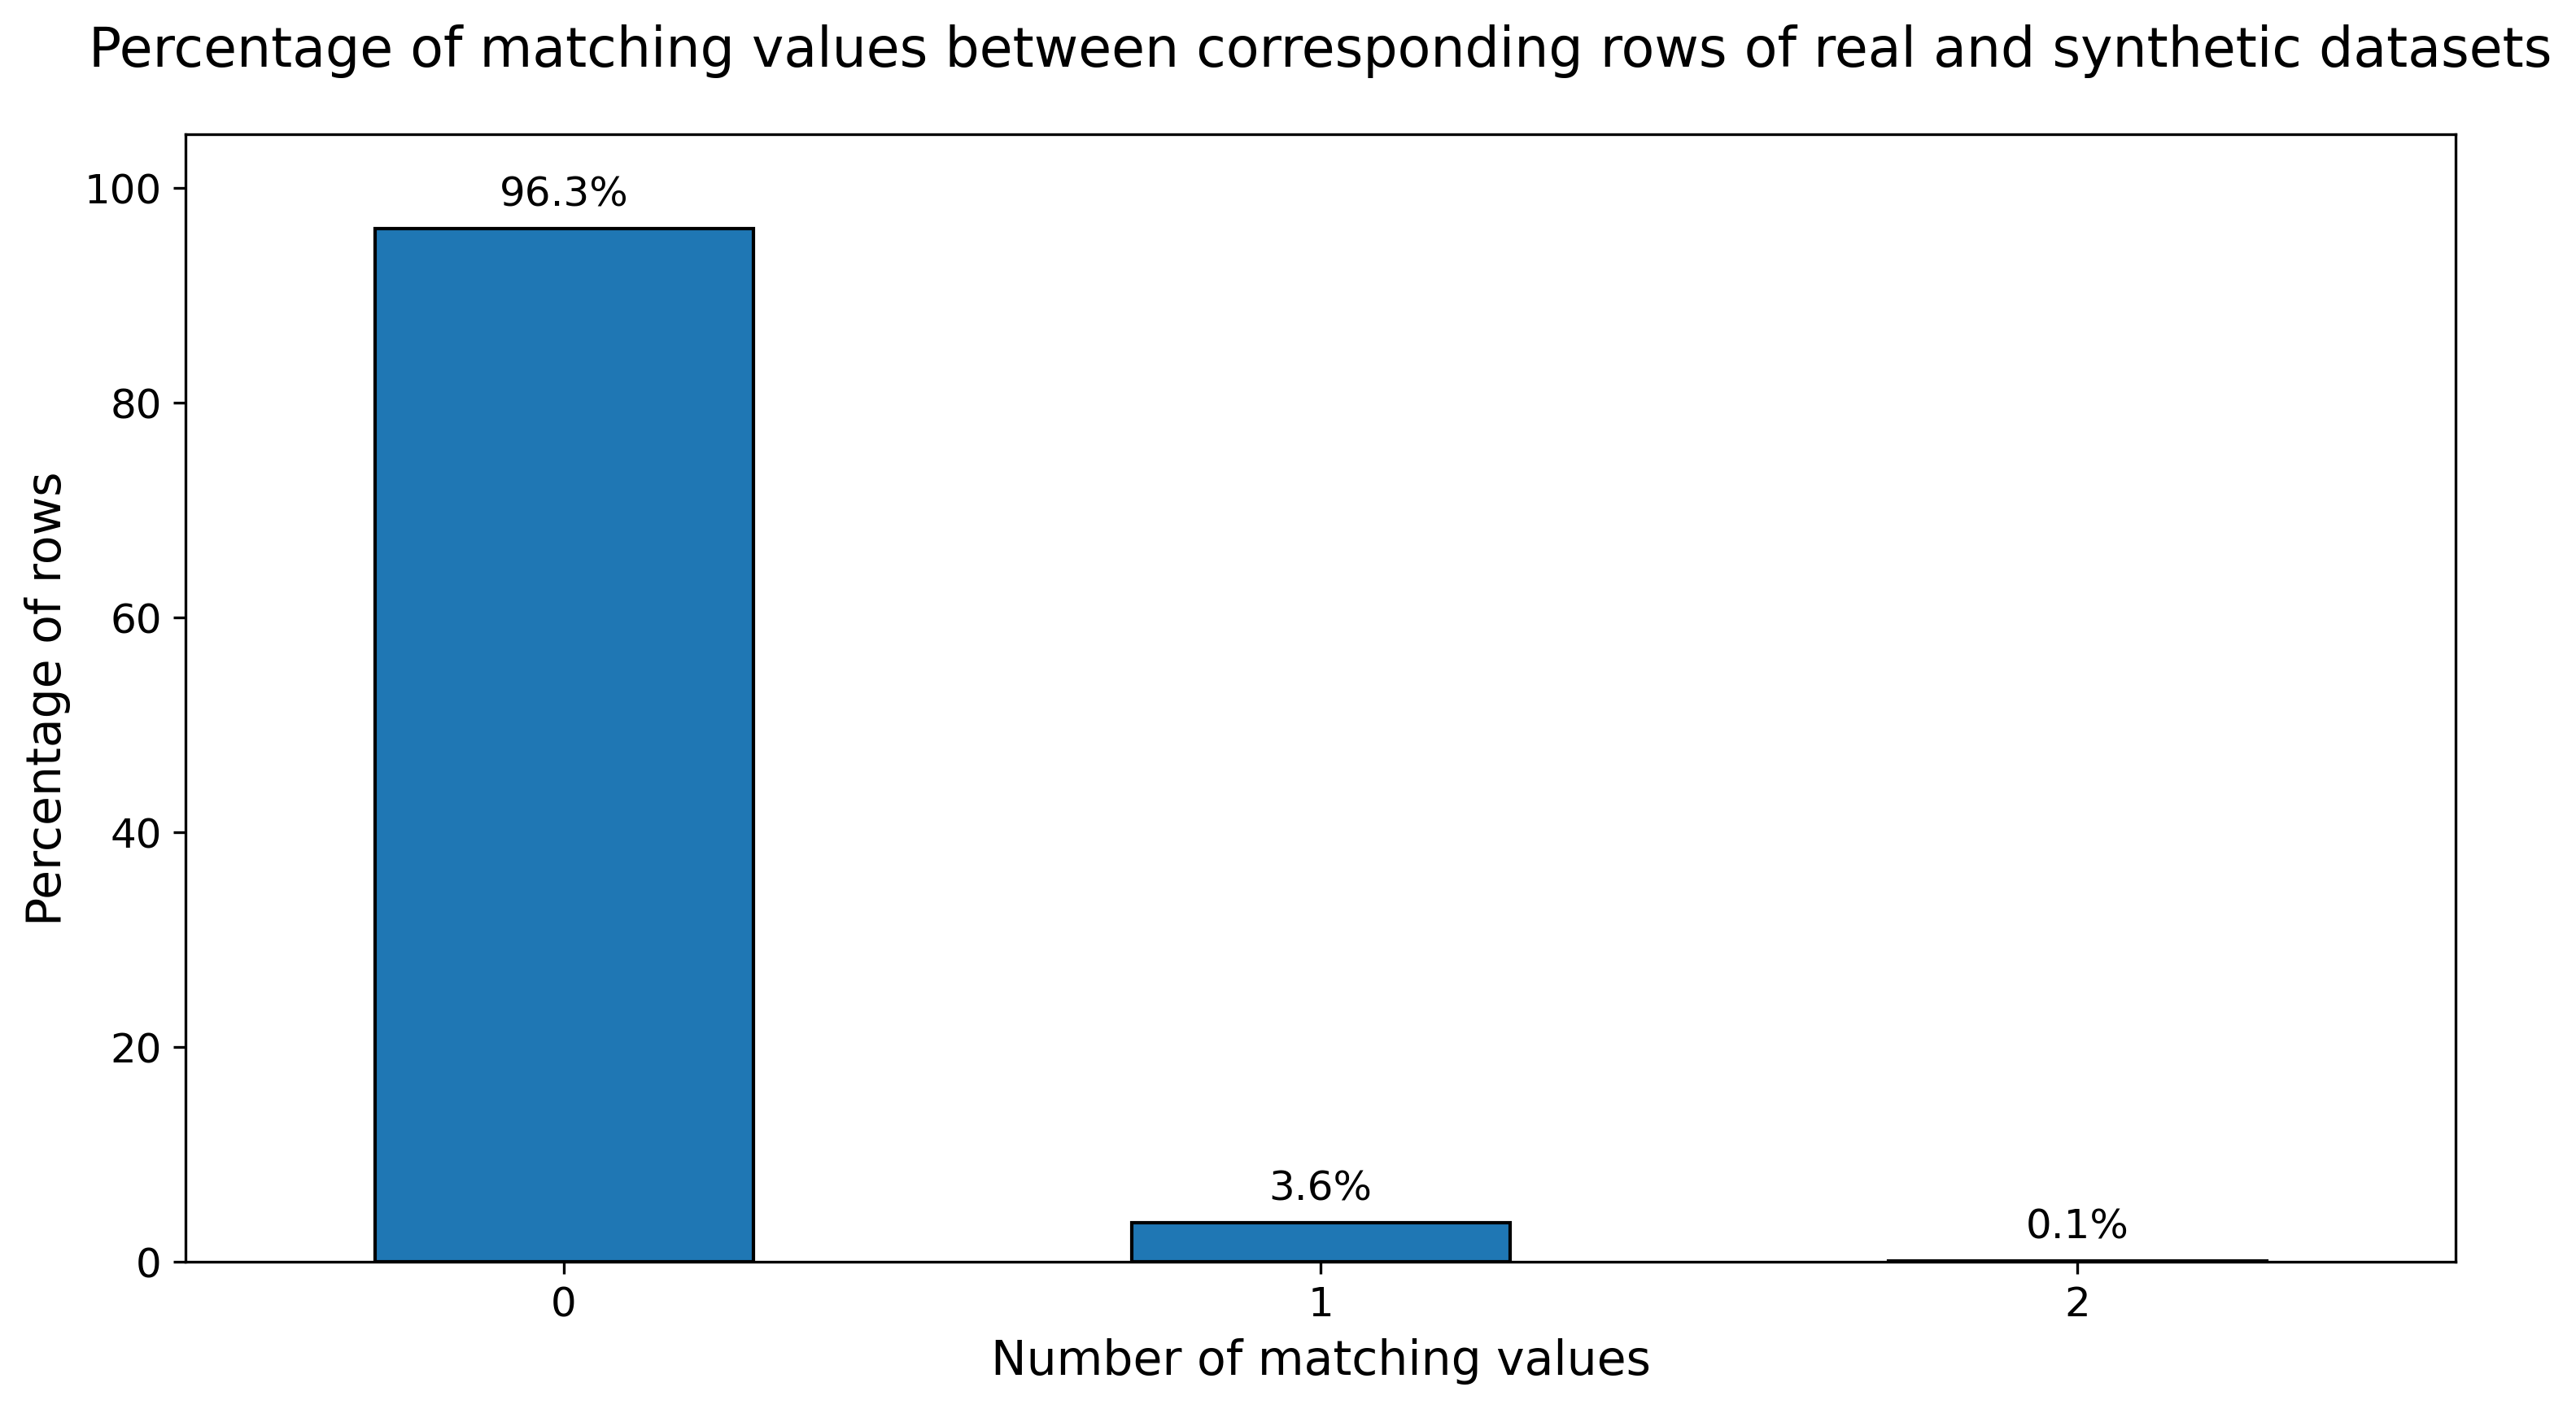

In [23]:
occurrences = pd.Series(distances).value_counts().sort_index()/len(distances) *100

plt.figure(figsize=(12, 6), dpi=300)
ax = occurrences.plot(kind='bar', color='#1f77b4', edgecolor='black')

plt.xlabel('Number of matching values', fontsize=14)
plt.ylabel('Percentage of rows', fontsize=14)
plt.title('Percentage of matching values between corresponding rows of real and synthetic datasets', fontsize=16, pad=20)

plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize=12,
                color='black')

plt.ylim(0, 105)

plt.show()

In [24]:
print("Report of Copied Variables:\n")
for variable, value in report.items():
    print(f"{variable.replace('_', ' ').capitalize()}: {value}")

Report of Copied Variables:

Max temperature: 28
Min temperature: 23
Solar exposure: 24
Demand: 1
Rrp: 3


### Discriminator

Another useful analysis can be conducted by implementing a ML discriminator that tries to detect synthetic data, in order to evaluate if these present any pattern that a ML model could find. We then implmented a RandomForest classifier, the datasets have been first labeled as `Real: 0` or `Synthetic: 1`, then merged and shuffled. On the merged dataset a static train-test-split has been applied and the classifier has been first trained and the tested.

In [25]:
def discriminator(real_data, synth_data):
    
    real_data['Synthetic'] = 0

    synth_data['Synthetic'] = 1
    
    combined_data = pd.concat([real_data, synth_data], axis=0)
    
    shuffled_df = combined_data.sample(frac=1).reset_index(drop=True)
    
    X = shuffled_df.drop('Synthetic', axis=1)
    y = shuffled_df['Synthetic']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    rf = RandomForestClassifier(n_estimators=100)

    rf.fit(X_train, y_train)

    predictions = rf.predict(X_test)

    print(confusion_matrix(y_test, predictions))
    print(classification_report(y_test, predictions))
    print('Accuracy: ', round(accuracy_score(y_test, predictions), 2))

In [26]:
df_filtered['school_day'] = df_filtered['school_day'].map({'Y': 1, 'N': 0})
df_sin['school_day'] = df_sin['school_day'].map({'Y': 1, 'N': 0})

In [27]:
df_F = df_filtered.drop(['Date'], axis=1)
df_S = df_sin.drop(['Date'], axis=1)

In [28]:
discriminator(df_F, df_S)

[[355 256]
 [279 360]]
              precision    recall  f1-score   support

           0       0.56      0.58      0.57       611
           1       0.58      0.56      0.57       639

    accuracy                           0.57      1250
   macro avg       0.57      0.57      0.57      1250
weighted avg       0.57      0.57      0.57      1250

Accuracy:  0.57


### Distance to the closest record (DCR)

To quantify the similarity between synthetic data and original data, we use a distance to closest record (DCR) calculation. This method involves two steps:

1. **Calculating the Euclidean Distance for Original Data**: For each datapoint in the original dataset, we calculate the Euclidean distance to its nearest neighbor within the same dataset.

2. **Calculating the Euclidean Distance for Synthetic Data**: For each synthetic datapoint, we calculate the Euclidean distance to the closest datapoint in the original dataset.

A greater synthetic-real DCR indicates that the synthetic datapoint is more distinct from the real datapoint, suggesting higher privacy since re-identification is more difficult. Conversely, a synthetic-real DCR close to 0 means that the synthetic datapoint closely resembles a real datapoint, offering little to no privacy protection.

Interpreting synthetic-real DCRs can be challenging because synthetic data points are designed to fall within the same range as the original data, increasing the likelihood of proximity to a real record. To address this, we compare the distribution of distances between synthetic records and real records with the distribution of distances among real records themselves. If the synthetic data is similar or farther from the real data compared to the real data's internal distances, it implies that the synthetic data provides good privacy privacy and is not merely a copy or simple perturbation of the real data.


In [29]:
def compute_dcr_optimized(real_df, synthetic_df):

    real_distances = cdist(real_df.values, real_df.values)
    np.fill_diagonal(real_distances, np.inf)
    
    synthetic_to_real_distances = cdist(synthetic_df.values, real_df.values)
    

    real_dcr = np.min(real_distances, axis=1)
    
    synthetic_dcr = np.min(synthetic_to_real_distances, axis=1)
    
    return real_dcr, synthetic_dcr

In [30]:
real_dcr_o, synthetic_dcr_o = compute_dcr_optimized(df_F, df_S)

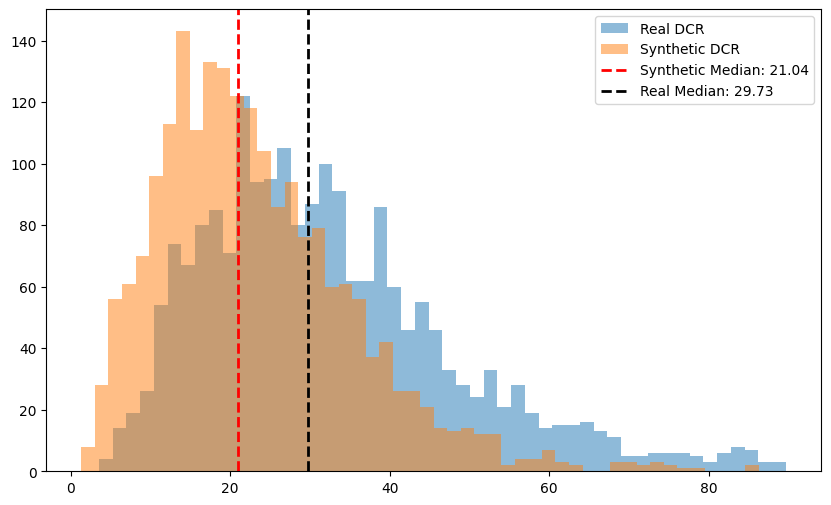

In [31]:
selected_values = synthetic_dcr_o[synthetic_dcr_o < 90]
sv = real_dcr_o[real_dcr_o < 90]
synth_median = np.median(selected_values)
real_median = np.median(sv)

plt.figure(figsize=(10, 6))

plt.hist(sv, bins = 50 ,alpha=0.5, label='Real DCR')
plt.hist(selected_values, bins = 50 ,alpha=0.5, label='Synthetic DCR')

plt.axvline(synth_median, color='red', linestyle='dashed', linewidth=2, label=f'Synthetic Median: {synth_median:.2f}')
plt.axvline(real_median, color='black', linestyle='dashed', linewidth=2, label=f'Real Median: {real_median:.2f}')

plt.legend()

plt.show()

### Machine learning efficiency (MLE)

As last we try to build a simple machine learning model on the data to compare the efficiency of synthetic data with respect to the real. To do this we **train** a model on the synthetic data and test it on the real, in order to verify how efficient the synthetic data would be. We then compare the accuracy of the model with the one of a model trained and testd on the real data. As model we use a simple ``RandomForest`` classifier, using as target variable ``schoolday``.

In [32]:
seed = 12

X_s = df_sin.drop(['school_day', 'Date'], axis=1)
y_s = df_sin['school_day']

X = df_filtered.drop(['school_day', 'Date'], axis=1)
y = df_filtered['school_day']

smote = SMOTE(random_state=seed)
X_resampled, y_resampled = smote.fit_resample(X, y)
X_s_resampled, y_s_resampled = smote.fit_resample(X_s, y_s)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=seed)

rf = RandomForestClassifier(n_estimators=100, random_state=seed)

rf.fit(X_s_resampled, y_s_resampled)

predictions = rf.predict(X_test)

print('======= Random Forest - SYNTHETIC train REAL test =======')
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print('                     Accuracy: ',round(accuracy_score(y_test, predictions),2),'\n')

rf = RandomForestClassifier(n_estimators=100, random_state=seed)

rf.fit(X_train, y_train)

predictions = rf.predict(X_test)

print('======= Random Forest - REAL train REAL test =======')
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print('                     Accuracy: ',round(accuracy_score(y_test, predictions),2),'\n')


======= Random Forest - SYNTHETIC train REAL test =======
[[252 176]
 [143 296]]
              precision    recall  f1-score   support

           0       0.64      0.59      0.61       428
           1       0.63      0.67      0.65       439

    accuracy                           0.63       867
   macro avg       0.63      0.63      0.63       867
weighted avg       0.63      0.63      0.63       867

                     Accuracy:  0.63 

======= Random Forest - REAL train REAL test =======
[[324 104]
 [132 307]]
              precision    recall  f1-score   support

           0       0.71      0.76      0.73       428
           1       0.75      0.70      0.72       439

    accuracy                           0.73       867
   macro avg       0.73      0.73      0.73       867
weighted avg       0.73      0.73      0.73       867

                     Accuracy:  0.73 

